In [1]:
import numpy as np
import matplotlib.pyplot as plt
from preprocess_images import data_from_folder


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import cv2 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
# data = data_from_folder("./data/laser_x4_y6")
data = data_from_folder("./data/test")

x1_y1.jpg


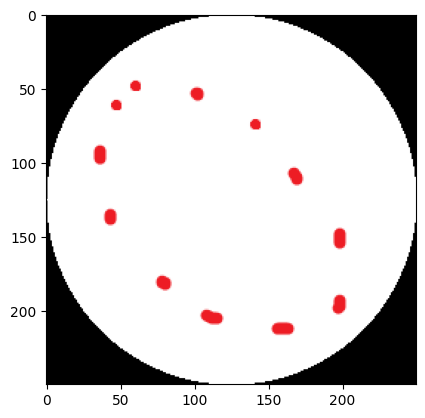

In [3]:
for k in data:
    print(k)
    plt.imshow(data[k], vmin=0, vmax=255)
    # plt.show()
    break

In [5]:
def imname_to_target(name:str) -> tuple[float]:
    """Parses image names of format x{x_value}_y{y_value}.jpg"""
    name = name.split('.jpg')[0]
    x, y = name.split("_")
    x = float(x[1:])
    y = float(y[1:])
    return x, y

In [6]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

        self.in_channels = 3
        if len(self.images[0].shape) == 2:
            self.in_channels = 1
        else:
            self.in_channels = self.images[0].shape[2] # TODO check
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]  # Get image (NumPy array)
        label = self.targets[idx]  # Get corresponding tuple

        # Convert image to Tensor and normalize [0,1]
        image = torch.from_numpy(image)
        if len(image.shape)==3:
            image = image.permute(2, 0, 1)  # HWC -> CHW
        else:
            image = image.unsqueeze(0)
        image = image.float() / 255.0

        # Convert label tuple to Tensor
        label = torch.tensor(label, dtype=torch.float32)

        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
config = {
    "batch_size": 64,
    "lr": 0.001,
}

In [8]:
# Prepare dataset
images = []
targets = []
for name, image in data.items():
    targets.append(imname_to_target(name))
    images.append(image)
dataset = ImageDataset(images, targets)
dataloader = DataLoader(dataset, config["batch_size"], True)

In [9]:
print(dataset[0][0].shape)
print(dataset.in_channels)

torch.Size([3, 250, 250])
3


In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, output_size, in_channels):
        super(SimpleCNN, self).__init__()

        self.sec1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 5, 2), # 3, 250 -> 32, 125
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32, 125 -> 32, 62

            nn.Conv2d(32, 64, 3, 2), # 32, 62 -> 64, 31
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64, 31 -> 64, 15

            nn.Conv2d(64, 128, 3, 2), # 64, 15 -> 128, 7
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128, 7 -> 128, 3
        )

        self.sec2 = nn.Sequential(
            nn.Linear(128*3*3, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
        )


    def forward(self, x):
        x = self.sec1(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.sec2(x)

        return x

In [16]:
model = SimpleCNN(output_size=2, in_channels=dataset.in_channels).to(DEVICE)
summary(model, (dataset.in_channels, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 123, 123]           2,432
              ReLU-2         [-1, 32, 123, 123]               0
         MaxPool2d-3           [-1, 32, 61, 61]               0
            Conv2d-4           [-1, 64, 30, 30]          18,496
              ReLU-5           [-1, 64, 30, 30]               0
         MaxPool2d-6           [-1, 64, 15, 15]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
              ReLU-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 3, 3]               0
           Linear-10                  [-1, 256]         295,168
             ReLU-11                  [-1, 256]               0
           Linear-12                    [-1, 2]             514
Total params: 390,466
Trainable params: 390,466
Non-trainable params: 0
-------------------------------